Objective: Because each data point costs more time than I would like, I would like to potentially reduce the range of URL IDs that we will have to scrape

Background: Each review has a unique identifier in its URL, and our review scraper works by visiting the URLs associated with identifiers randomly selected from within a numerical range. I initially selected a range over the summer based on a preliminary scrape of about 6K URL IDs. My goal was to select a minimum ID cut-off that demark a range of reviews starting in January of 2018. However, because I wasn't confident in my analysis and wanted to be conservative, I selected a range of about 2.1 B reviews, which I estimated captured reviews starting in January 2017. 

At this point, I have significantly more data and more tool with which to analyze the problem more precisely. I would therefore like to revisit the analysis, in hopes of narrowing the range. 

In [1]:
#Importing Libraries
from datetime import datetime
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy

import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report, confusion_matrix

This data comes from the most up-to-date version of the review database. The columns should convey the following: 

id: the unique identifier which can be found in the URL of each review
pub_date: the publication date of each review
pub_date_ordinal: a transformation of the publication date
pub_year: review publication year

In [2]:
#Importing & Cleaning Data
review_df = pd.read_csv("databases/review_data.csv", usecols=["review_id", "is_URL_valid", "review_publication_date"])
#review_df = review_df.head(500)

review_df = review_df[review_df.is_URL_valid == True] #Removing IDS which do not have an associated review. In my previous analysis these appeared to be random. I hypothesize that they were once associated with reviews which have since been deleted.
review_df.drop(columns = "is_URL_valid", inplace = True)
review_df.dropna(inplace = True)
review_df.drop_duplicates(inplace = True)
review_df.reset_index(inplace = True, drop = True)
review_df.rename(columns = {"review_id": "id", "review_publication_date": "pub_date"}, inplace = True)

#Transforming Publication Dates
review_df["pub_date_ordinal"] = pd.to_datetime(review_df["pub_date"]).apply(lambda date: date.toordinal())
review_df["pub_year"] = pd.to_datetime(review_df["pub_date"]).apply(lambda date: date.year)
 
print(review_df.head(5))

C:\Users\Leora Rosenberg\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


             id     pub_date  pub_date_ordinal  pub_year
0  1.747113e+09  Sep 03 2016            736210      2016
1  2.835829e+09  May 27 2019            737206      2019
2  1.804766e+09  Nov 06 2016            736274      2016
3  3.127147e+09  Jan 11 2020            737435      2020
4  2.659557e+09  Jan 05 2019            737064      2019


I am putting all my math and visualization stuff in this cell right here. I would love to collapse this code, but I don't think Jupyter does that. 

In [3]:
class Regression_Visualizer():

    def __init__(self, df):

        self.df = df
        
        plt.close("all") #BECAUSE JUPYTER NOTEBOOKS SUCK

        with sns.axes_style("white"):
            ax = sns.regplot(x = "pub_date_ordinal", y = "id",  data = self.df, ci = None, marker = ".", scatter_kws= {"alpha": 0.5}, line_kws = {"color": "gray"})

            ax.set_ylim(self.df.id.min(), self.df.id.max())
            ax.set_xlabel("Review Publication Date")
            ax.set_ylabel("Review ID")
            new_xlabels = [date.fromordinal(int(x_val)) for x_val in ax.get_xticks() ]
            ax.set_xticklabels(new_xlabels)
            plt.xticks(rotation = 90)

            plt.title("Review URL IDs by Date")

        plt.show()

    def print_pearson(self):

        r, p = scipy.stats.pearsonr(self.df.id, self.df.pub_date_ordinal)

        print("r = {:.2}, p = {:.3}, two tailed".format(r, p))

class Decision_Tree():

    def __init__(self, df, min_year):

        self.df = review_df.copy()
        self.split = 0.8 #NO REASON NOT TO GO WITH THE RULE OF THUMB
        self.min_year = min_year
        
        self.df["is_in_period"] = np.where(self.df["pub_year"] >= self.min_year, 1, 0)
                
        self.df.drop(columns = ["pub_date_ordinal", "pub_year"], inplace = True)
        
        self.split_data() #Do this in the init so that you use the same split for each potential depth.

    def split_data(self):

        num_observations_total = len(self.df)
        num_observations_train = int(num_observations_total* self.split)
        num_observations_test = num_observations_total - num_observations_train
        
        self.df = self.df.iloc[np.random.permutation(self.df.index)].reset_index(drop=True)

        self.train_df = self.df.head(num_observations_train).reset_index(drop = True)
        self.test_df = self.df.tail(num_observations_test).reset_index(drop = True)

        self.x_train, self.y_train = self.train_df.id, self.train_df.is_in_period
        self.x_test, self.y_test = self.test_df.id, self.test_df.is_in_period

        self.x_train = self.x_train.values.reshape(-1, 1)
        self.y_train = self.y_train.values.reshape(-1, 1)
        self.x_test = self.x_test.values.reshape(-1, 1)
        self.y_test = self.y_test.values.reshape(-1, 1)

    def fit_tree(self, depth = None):

        self.clf = DecisionTreeClassifier(criterion="entropy", max_depth = depth)
        self.clf = self.clf.fit(self.x_train, self.y_train)

    def print_tree_accuracy(self):

        pred_train = self.clf.predict(self.x_train)
        pred_test = self.clf.predict(self.x_test)

        print("Training Data:")
        print(classification_report(self.y_train, pred_train))

        print("Test Data:")
        print(classification_report(self.y_test, pred_test))

    def show_tree(self):
        
        plt.close("all") #BECAUSE JUPYTER NOTEBOOKS SUCK

        plt.figure(figsize = (10,10))
        sklearn.tree.plot_tree(self.clf, feature_names= ["id"])
        plt.show()
        
    def test_tree_depths(self, max_depth_list):
        
        plt.close("all") #BECAUSE JUPYTER NOTEBOOKS SUCK
        
        for depth in max_depth_list:
            self.fit_tree(depth)
        
            print("Max Depth: {}".format(depth))
            self.print_tree_accuracy()
            self.show_tree()
        

As a first step, I want to visualize the relationship between review ID and review publication date. Based on previous analysis, I expect this to be roughly linear, with the exception of some short periods in which different systems appeared to be used. 

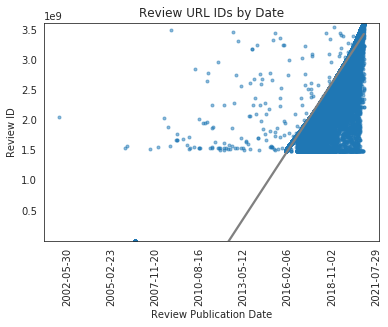

r = 0.98, p = 0.0, two tailed


In [4]:
regression_full_data = Regression_Visualizer(review_df)
regression_full_data.print_pearson()

That image is misleading. Because there are so many points, many populated areas of the graph appear solid, masking variations in their relative densities. We can see from the pearson values that the relationship is almost perfectly linear. Based on the image alone, I would consider the possibility that an polynomial curve would more closely capture the relationship, which would sense if the rate at which users leave reviews accelerates over time. However, the linear description is close enough that I don't want to spend time exploring. 

Because a lot of the data comes from ancient history and apparently from the future (??), I would like to narrow in on the period that actually interests me. 

C:\Users\Leora Rosenberg\miniconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


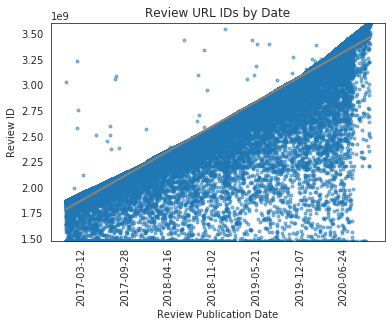

r = 0.97, p = 0.0, two tailed


In [5]:
review_df_trunc = review_df.copy()
review_df_trunc = review_df_trunc[review_df.pub_year >= 2017]
review_df_trunc = review_df_trunc[review_df.pub_year <= 2020]

regression_trunc_data = Regression_Visualizer(review_df_trunc)
regression_trunc_data.print_pearson()

The story is quite similar: the relationship is almost perfectly linear. I can also see that the model's inaccuracy is skewed in one direction (the residuals are not random! that never happens in stats class!): many review ids have publication dates later than would be predicted by the regression, but very few have publication dates earlier than would be predicted by the regression. Because I'm actually looking for a cutoff point rather than a prediction, that means that much of the error is irrelevant to the problem I'm trying to solve. In other words, the prediction is more valuable than the r-value would suggest. Regression, because it cares about errors in both directions and because it cares about magnitude of error, is actually not the perfect tool for this problem. 

If I reduce all dates to a binary in-period-of-interest or out-of-period-of-interest classification, the problem is better suited to creating a split. A couple of thoughts and caveats: 

First, in simplifying the decision-criteria, I'm taking a step away from the problem that I am ultimately trying to solve because the binary view of the time periods could potentially mask a skewed selection of dates. For example, this approach would correctly identify a range of reviews written on July 4th of 2018 as all falling within the 2018-2020 time period, but a sample comprised entirely of those reviews won't speak to change over time. I'll need to keep an eye on the purity of my splits in order to evaluate how much relevant data the suggested splits would exclude. 

Second, even though it would be much easier (and less memory-intensive) to input a single range of numbers into the scraper, I will also consider the possibilitiy of multiple splits. The initial analysis from over the summer suggested particular periods in which the general relationship between the IDs and review dates broke down, as if the site one day decided to reuse old identifiers for new reviews, so I would not be surprised to discover that the best fit is several non contigous ranges. I plan to test small numbers of splits and be biased towards the simplest model in which the accuracy is not prohibitively low. I suspect that with a single feature, and a small number of splits allowed, I feel like a single setting should be sufficient to control complexity. I think it's max depth. 

I also need to consider what success looks like by comparing the cost of false positives (out of period, in scraping range) versus false negatives (in period, out of scraping range) on the analysis. False positives cause us to lose time scraping data that we will then need to discard. False negatives are more complicated because their impact depends on whether or not they occur at random. If the data that gets excluded from our scraping range is random, it would have no cost. However, because the data is pretty linear, I feel comfortable assuming that the false negatives would be located at the start of the historical time period. To make it concrete, let's say that data from January of 2018 is underrepresented - what impact does that have? The false negatives should remain random with respect to the books covered by the missing reviews, which is good. However, a severe underrepresentation of January might depress any predictive power associated with data from that month. I'm going to use accuracy to start, but I want to keep an eye on the values associated with purity of the out-of-range. 

Modeling 2017 cutoff
Max Depth: 1
Training Data:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     74288
           1       1.00      0.99      1.00    250537

    accuracy                           0.99    324825
   macro avg       0.99      1.00      0.99    324825
weighted avg       0.99      0.99      0.99    324825

Test Data:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18454
           1       1.00      0.99      1.00     62753

    accuracy                           0.99     81207
   macro avg       0.99      1.00      0.99     81207
weighted avg       0.99      0.99      0.99     81207



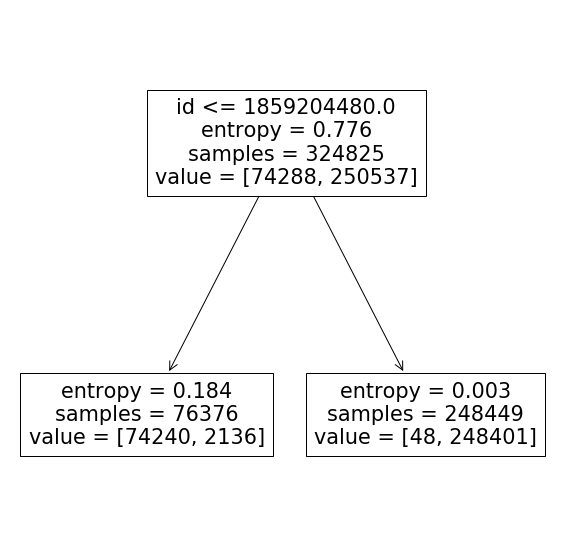

Max Depth: 2
Training Data:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     74288
           1       1.00      0.99      1.00    250537

    accuracy                           0.99    324825
   macro avg       0.99      1.00      0.99    324825
weighted avg       0.99      0.99      0.99    324825

Test Data:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18454
           1       1.00      0.99      1.00     62753

    accuracy                           0.99     81207
   macro avg       0.99      1.00      0.99     81207
weighted avg       0.99      0.99      0.99     81207



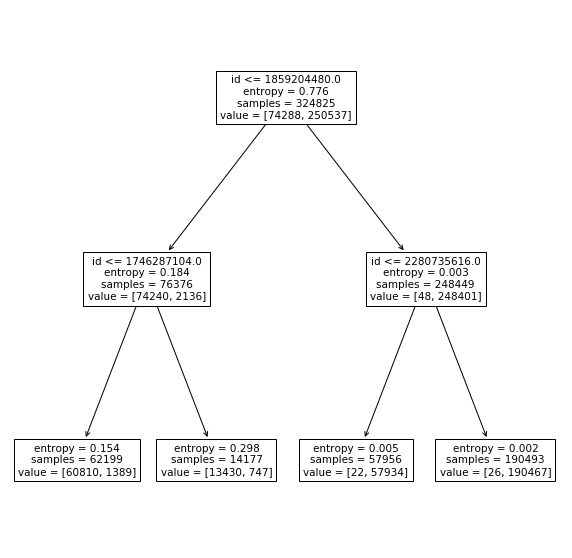

Max Depth: 3
Training Data:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     74288
           1       1.00      0.99      1.00    250537

    accuracy                           0.99    324825
   macro avg       0.99      1.00      0.99    324825
weighted avg       0.99      0.99      0.99    324825

Test Data:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18454
           1       1.00      0.99      1.00     62753

    accuracy                           0.99     81207
   macro avg       0.99      1.00      0.99     81207
weighted avg       0.99      0.99      0.99     81207



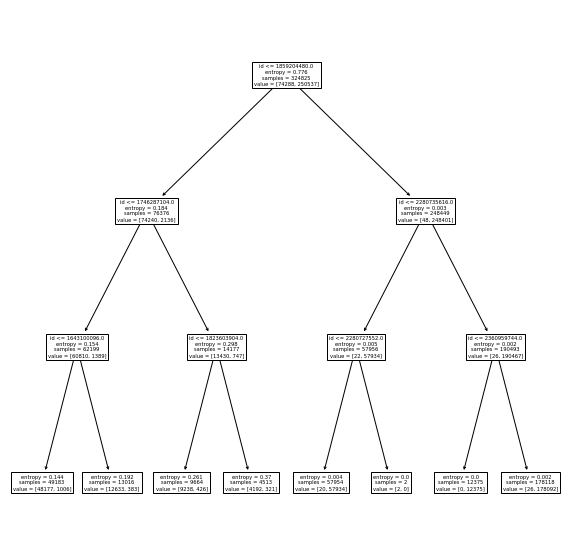

Modeling 2018 cutoff
Max Depth: 1
Training Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    124511
           1       1.00      0.99      0.99    200314

    accuracy                           0.99    324825
   macro avg       0.99      0.99      0.99    324825
weighted avg       0.99      0.99      0.99    324825

Test Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     31279
           1       1.00      0.99      0.99     49928

    accuracy                           0.99     81207
   macro avg       0.99      0.99      0.99     81207
weighted avg       0.99      0.99      0.99     81207



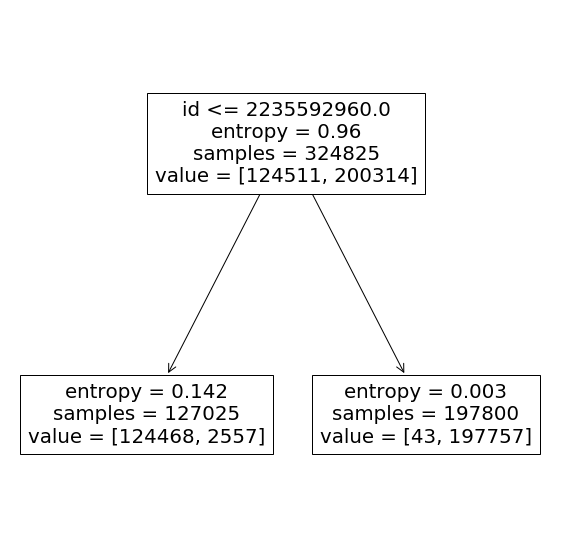

Max Depth: 2
Training Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    124511
           1       1.00      0.99      0.99    200314

    accuracy                           0.99    324825
   macro avg       0.99      0.99      0.99    324825
weighted avg       0.99      0.99      0.99    324825

Test Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     31279
           1       1.00      0.99      0.99     49928

    accuracy                           0.99     81207
   macro avg       0.99      0.99      0.99     81207
weighted avg       0.99      0.99      0.99     81207



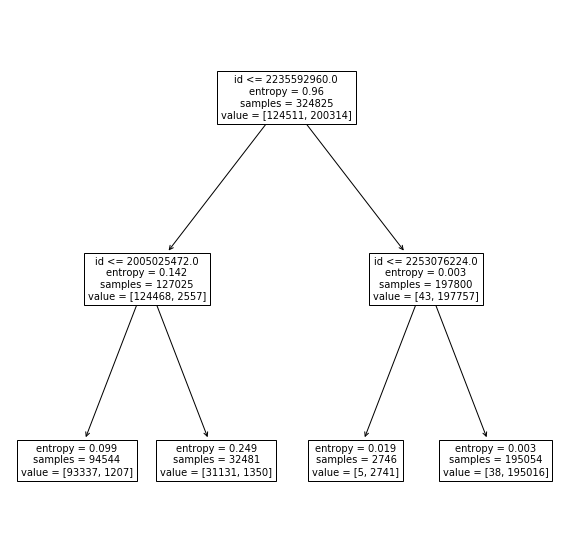

Max Depth: 3
Training Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    124511
           1       1.00      0.99      0.99    200314

    accuracy                           0.99    324825
   macro avg       0.99      0.99      0.99    324825
weighted avg       0.99      0.99      0.99    324825

Test Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     31279
           1       1.00      0.99      0.99     49928

    accuracy                           0.99     81207
   macro avg       0.99      0.99      0.99     81207
weighted avg       0.99      0.99      0.99     81207



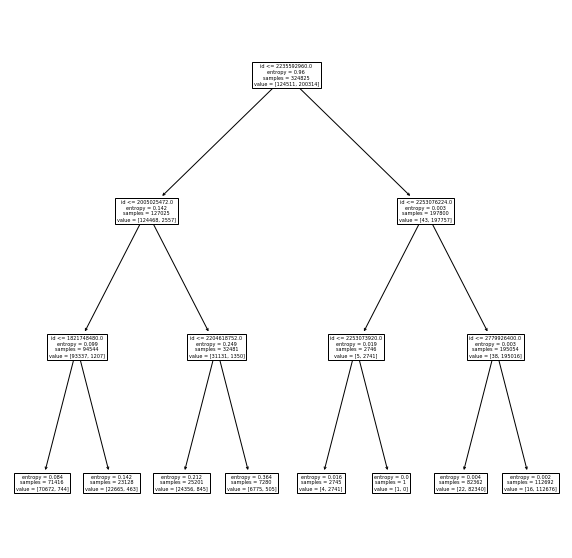

In [6]:
depth_list = range(1, 4) #I'M NOT EVEN GOING TO TEST HIGHER NUMBERS UNLESS THESE COME BACK WITH LOW ACCURACY
year_list = [2017, 2018]

for year in year_list:
    print("Modeling {} cutoff".format(year))
    splitting_tree = Decision_Tree(review_df, year)
    splitting_tree.test_tree_depths(depth_list)

These have very high accuracy across the board, which seems too good to be true. However, given the strenght of the linear correlation, it might not mean the result is invalid. For both 2017 and 2018 cutoffs, the single depth (ie, max_depth = 1) has sufficient performance to justify ignoring the more complex models. The 2018 model looks good in that it has 0.99 accuracy on test data and all the other metrics are great too. 

Max Depth: 1
Training Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    124708
           1       1.00      0.99      0.99    200117

    accuracy                           0.99    324825
   macro avg       0.99      0.99      0.99    324825
weighted avg       0.99      0.99      0.99    324825

Test Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     31082
           1       1.00      0.99      0.99     50125

    accuracy                           0.99     81207
   macro avg       0.99      0.99      0.99     81207
weighted avg       0.99      0.99      0.99     81207



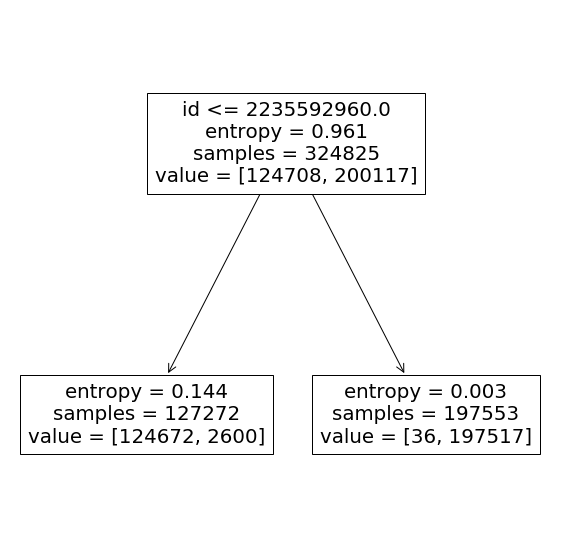

Max Depth: 2
Training Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    124708
           1       1.00      0.99      0.99    200117

    accuracy                           0.99    324825
   macro avg       0.99      0.99      0.99    324825
weighted avg       0.99      0.99      0.99    324825

Test Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     31082
           1       1.00      0.99      0.99     50125

    accuracy                           0.99     81207
   macro avg       0.99      0.99      0.99     81207
weighted avg       0.99      0.99      0.99     81207



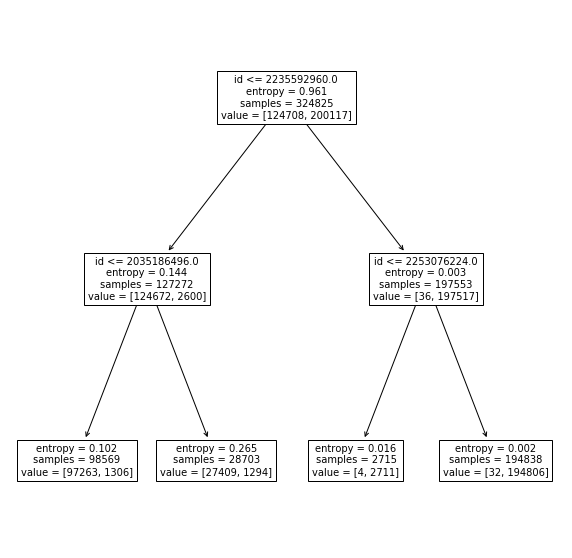

Max Depth: 3
Training Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    124708
           1       1.00      0.99      0.99    200117

    accuracy                           0.99    324825
   macro avg       0.99      0.99      0.99    324825
weighted avg       0.99      0.99      0.99    324825

Test Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     31082
           1       1.00      0.99      0.99     50125

    accuracy                           0.99     81207
   macro avg       0.99      0.99      0.99     81207
weighted avg       0.99      0.99      0.99     81207



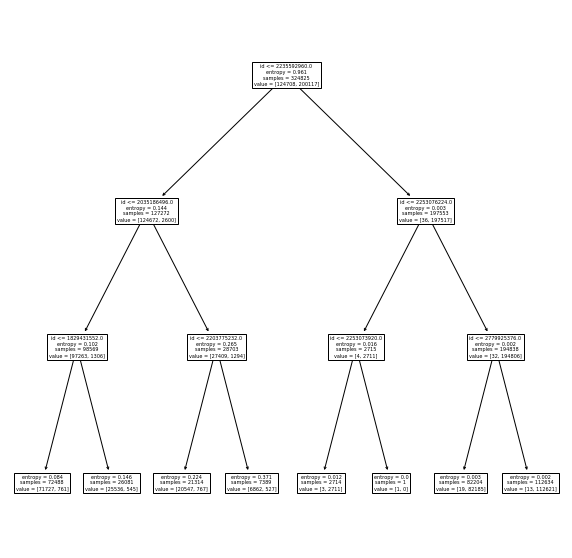

Max Depth: 4
Training Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    124708
           1       1.00      0.99      0.99    200117

    accuracy                           0.99    324825
   macro avg       0.99      0.99      0.99    324825
weighted avg       0.99      0.99      0.99    324825

Test Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     31082
           1       1.00      0.99      0.99     50125

    accuracy                           0.99     81207
   macro avg       0.99      0.99      0.99     81207
weighted avg       0.99      0.99      0.99     81207



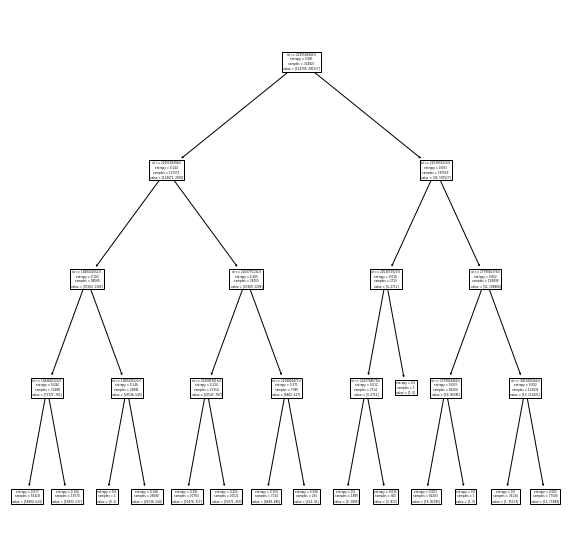

In [7]:
depth_list = range(1, 5)

test_tree_2017 = Decision_Tree(review_df, 2018)
test_tree_2017.test_tree_depths(depth_list)

The last thing that I want to understand is whether this model leads us to a smaller range of potentially relevant IDs. 

In [8]:
max_id = 3607950182 #id assigned to a review I wrote this week
min_id_prev_estimate = 1484362322
min_id_2017, min_id_2018 = 1859200000, 2235559808

population_count_prev_estimate = max_id - min_id_prev_estimate
population_count_2017 = max_id - min_id_2017
population_count_2018 = max_id - min_id_2018

print("""
Prev Estimate:  {:.1E} points
2017 - 2020: {:.1E} points, {:.2%} reduction in scope
2018 - 2020: {:.1E} points, {:.2%} reduction in scope
""". format(population_count_prev_estimate, population_count_2017, (population_count_2017 - population_count_prev_estimate)/population_count_prev_estimate, population_count_2018, (population_count_2018 - population_count_prev_estimate)/population_count_prev_estimate))


Prev Estimate:  2.1E+09 points
2017 - 2020: 1.7E+09 points, -17.65% reduction in scope
2018 - 2020: 1.4E+09 points, -35.37% reduction in scope



Next Steps: The risk of a mistake with these estimations would be that we would introduce a data hole into our scraped data, most likely at the start of 2018. We can protect against this by periodically examining the distribution of dates for reviews scraped based on these new estimations. A gap in dates, especially at the start of 2018, would indicate that we should revisit this analysis. We're scraping based on these estimations starting on 10/24/2020, so any audits should be limited to data scraped after that date. 

We can also estimate percent of reviews within the target range scraped.

In [10]:
num_totals_ids_in_range_est = population_count_2018

review_df_in_range = review_df.copy()
review_df_in_range = review_df_in_range[review_df.pub_year >= 2018]
review_df_in_range = review_df_in_range[review_df.pub_year <= 2020]

num_ids_in_range_scraped = len(review_df_in_range)
perc_of_population = 100* num_ids_in_range_scraped / num_totals_ids_in_range_est

print(perc_of_population)

0.018234024716352316


C:\Users\Leora Rosenberg\miniconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
